## Paper and data:

https://zenodo.org/records/13357926

https://www.nature.com/articles/s41563-024-02016-6

using stem ae and shuyu's affine transform code


In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/home/xz498/NaCl_STEM/m3_learning/src/')
sys.path.append('/home/xz498/NaCl_STEM/Gaussian_Sampler/')
# sys.path.append('/home/xz498/anaconda3/envs/nacl_stem/lib/python3.10/site-packages/m3_learning/m3_learning/src')

from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
import py4DSTEM

from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.viz.printing import printer

2024-11-19 14:32:39.269304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 14:32:39.282638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 14:32:39.286671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:32:39.298898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 14:32:40.128260: W tensorflow/compiler/tf2

In [88]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


<Figure size 640x480 with 0 Axes>

### test mnist

In [58]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [55]:
data = mnist.data.reshape(-1, 28, 28)

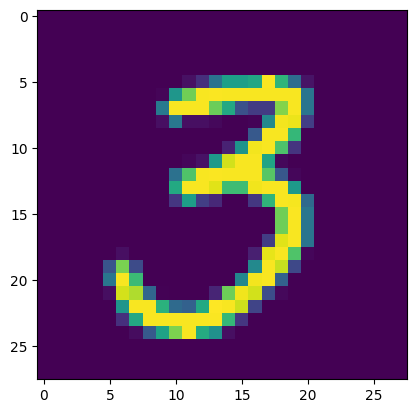

In [57]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=32, shuffle=True)
batch = next(iter(dataloader))
plt.imshow(batch[0].numpy())

In [71]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler, custom_collate_fn
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_AE_2D_module, Affine_Transform
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=None,
                     sampler_kwargs={},
                    #  sampler_kwargs={'dset': dataset,
                    #                  'orig_shape': dataset.data.shape,
                    #                  'batch_size': 16,
                    #                  'gaussian_std': 2,
                    #                  'num_neighbors': 16},
                     collate_fn=None,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [28,28], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                            #    'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 1.58,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [28,28], 
                                        'pooling_list': [2,2], 
                                        'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        # 'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [7,7], 
                                        'upsampling_list': [2,2], 
                                        'embedding_size': 32, 
                                        'conv_size': 128,
                                        'pooling_list': [2,2], 
                                        # 'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                     # STEM AE kwargs:
                     encoder_step_size=[28,28],
                     pooling_list=[4],
                     decoder_step_size=[22, 22],
                     upsampling_list=[8],
                     embedding_size=32,
                     conv_size=128,
                    #  device='cuda:1',
                     learning_rate=3e-5
                    )

In [84]:
model.Train(data,
        coef_1=0.,
        epochs=10,
        with_scheduler=False,
        folder_path="./",
        batch_size=256
)

100%|██████████| 274/274 [00:38<00:00,  7.13it/s]


Epoch: 000/010 | Train Loss: 2169.1353
.............................


100%|██████████| 274/274 [00:38<00:00,  7.20it/s]


Epoch: 001/010 | Train Loss: 1787.5651
.............................


100%|██████████| 274/274 [00:38<00:00,  7.12it/s]


Epoch: 002/010 | Train Loss: 1562.3535
.............................


100%|██████████| 274/274 [00:38<00:00,  7.04it/s]


Epoch: 003/010 | Train Loss: 1403.7934
.............................


100%|██████████| 274/274 [00:38<00:00,  7.07it/s]


Epoch: 004/010 | Train Loss: 1283.1748
.............................


100%|██████████| 274/274 [00:38<00:00,  7.10it/s]


Epoch: 005/010 | Train Loss: 1186.3263
.............................


100%|██████████| 274/274 [00:38<00:00,  7.08it/s]


Epoch: 006/010 | Train Loss: 1106.7563
.............................


100%|██████████| 274/274 [00:38<00:00,  7.09it/s]


Epoch: 007/010 | Train Loss: 1039.9203
.............................


 19%|█▉        | 52/274 [00:07<00:32,  6.93it/s]


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=32, shuffle=True)
batch = next(iter(dataloader))
plt.imshow(batch[0].numpy())

In [103]:
out = model.autoencoder(batch.float().to('cuda:3'))
predicted_x, embedding, t, r, sc, sh, m = (out_.reshape(32,-1).cpu().detach().numpy() if out_ is not None else None for out_ in out)
theta = get_theta(r)

In [104]:
theta.shape

(32,)

In [105]:
r.shape

(32, 6)

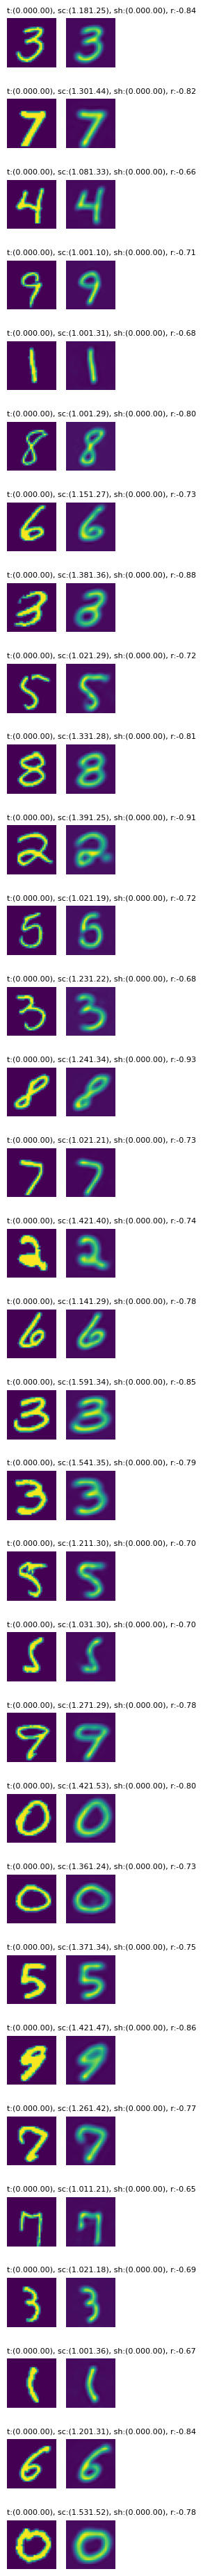

In [108]:
fig, ax = plt.subplots(len(batch), 2, figsize=(2,len(batch)*1.5))
for i in range(len(batch)):
    ax[i, 0].imshow(batch[i].reshape(28,28))
    ax[i, 1].imshow(predicted_x[i].reshape(28,28))
    ax[i,0].set_title(f't:({t[i,2]:.2f}{t[i,5]:.2f}), sc:({sc[i,0]:.2f}{sc[i,4]:.2f}), sh:({sh[i,1]:.2f}{sh[i,3]:.2f}), r:{theta[i,]:.2f}', 
                      loc='left', fontsize=8)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

In [74]:
debug

> /home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py(214)forward()
    212             b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
    213             b3 = torch.stack((a_5,a_5), dim=1).squeeze()
--> 214             rotation = torch.stack((b1, b2, b3), dim=2)
    215         else: rotation = None
    216 

torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
*** IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)


In [ ]:
debug